In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt 
%matplotlib inline


import os

import json

import itertools

from pickle import load,dump

from sklearn.model_selection import KFold,StratifiedKFold,LeaveOneOut,ShuffleSplit,cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import train_test_split


In [2]:
with open('target', 'rb') as pickle_file:
    y = load(pickle_file)

In [3]:
with open('processed_squats', 'rb') as pickle_file:
    X = load(pickle_file)

In [4]:
class_labels = {}

class_labels[0] = 'correct'
class_labels[1] = 'incorrect_chin_tuck'
class_labels[2] = 'incorrect_lean_fwd'
class_labels[3] = 'incorrect_feet_close'
class_labels[4] = 'incorrect_not_low'
class_labels[5] = 'incorrect_out_knees'

# PCA


In [5]:
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler


In [6]:
pca = PCA(n_components = 40)
pca.fit(X)

PCA(n_components=40)

Text(0, 0.5, 'Explained variance')

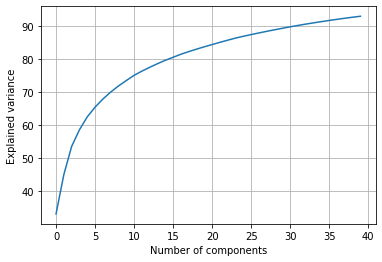

In [7]:
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

In [8]:
X_t = pca.transform(X)
X_t.shape

(296, 40)

## Visualising the dataset

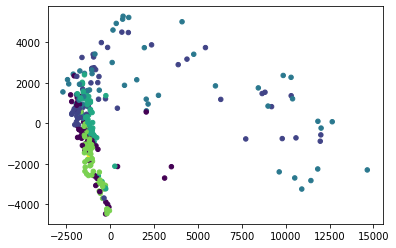

In [57]:
pca_2 = PCA(n_components = 2)

pca_2.fit(X)
X_t2 = pca_2.transform(X)

plt.scatter(X_t2[:,0],X_t2[:,1],c=y, s= 20)



## Creating the different folds to be used when scoring the models


In [10]:
k_folds = KFold(n_splits = 5)
sk_folds = StratifiedKFold(n_splits = 5)
loo = LeaveOneOut()
ss = ShuffleSplit(train_size=0.7, test_size=0.2, n_splits = 5)
labels = ['correct','incorrect_chin_tuck','incorrect_lean_fwd','incorrect_feet_close','incorrect_not_low']
cross_vals = ['K_fold','Stratified_K_fold','Leave_One_Out','Shuffle_split']



## Support Vector Classifier


In [11]:
from sklearn.svm import SVC


In [12]:

X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.1, random_state=42)

In [28]:
svc = SVC(C=48)

svc.fit(X_train,y_train)
svc.score(X_test,y_test)

0.9333333333333333

In [29]:
scores = cross_val_score(svc, X, y, cv = ss)

In [30]:
C_val = np.arange(1,101)

In [31]:
accuracies = []
for i in C_val:
    svc = SVC(C=i)
    svc.fit(X_train,y_train)
    score = svc.score(X_test,y_test)
    accuracies.append(score)
    

In [32]:

accuracies_linear = []
for i in C_val:
    svc = SVC(C=i,kernel='linear')
    svc.fit(X_train,y_train)
    score = svc.score(X_test,y_test)
    accuracies_linear.append(score)


In [33]:
accuracies_sigmoid = []
for i in C_val:
    svc = SVC(C=i,kernel='sigmoid')
    svc.fit(X_train,y_train)
    score = svc.score(X_test,y_test)
    accuracies_sigmoid.append(score)


In [34]:
accuracies_poly = []
for i in C_val:
    svc = SVC(C=i,kernel='poly')
    svc.fit(X_train,y_train)
    score = svc.score(X_test,y_test)
    accuracies_poly.append(score)


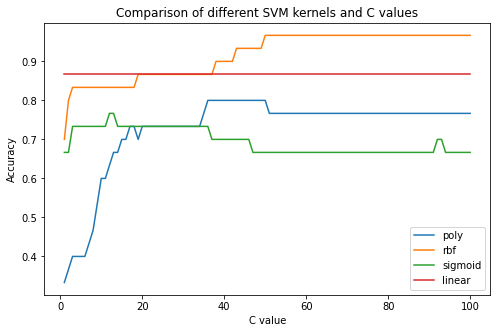

In [35]:
plt.figure(figsize=(8,5))
plt.title("Comparison of different SVM kernels and C values")
plt.xlabel("C value")
plt.ylabel("Accuracy")
plt.plot(C_val,accuracies_poly,label='poly')
plt.plot(C_val,accuracies,label='rbf')
plt.plot(C_val,accuracies_sigmoid,label='sigmoid')
plt.plot(C_val,accuracies_linear,label = 'linear')
plt.legend()
plt.show()



In [36]:
print(accuracies.index(max(accuracies)))

49


In [37]:
scores_kf_f1 = cross_val_score(svc, X, y, cv = k_folds,scoring='f1_micro')
scores_skf_f1 = cross_val_score(svc, X, y, cv = sk_folds,scoring='f1_micro')
scores_loo_f1 = cross_val_score(svc, X, y, cv = loo,scoring='f1_micro')
scores_ss_f1 = cross_val_score(svc, X, y, cv = ss,scoring='f1_micro')


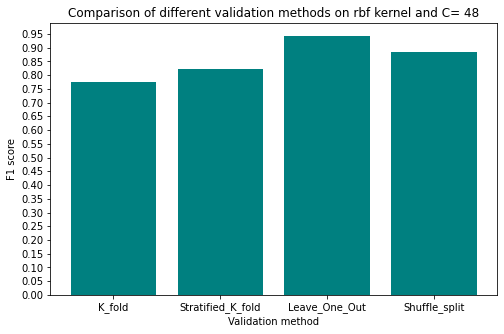

In [38]:
results = [scores_kf_f1.mean(),scores_skf_f1.mean(),scores_loo_f1.mean(),scores_ss_f1.mean()]


plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on rbf kernel and C= 48")
plt.xlabel("Validation method")
plt.ylabel("F1 score")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results,color='teal')
plt.show() 


In [71]:
print(scores_skf_f1.mean())

0.8241242937853107


In [73]:
cross_vals = ['K_fold','Stratified_K_fold','Leave_One_Out','Shuffle_split']


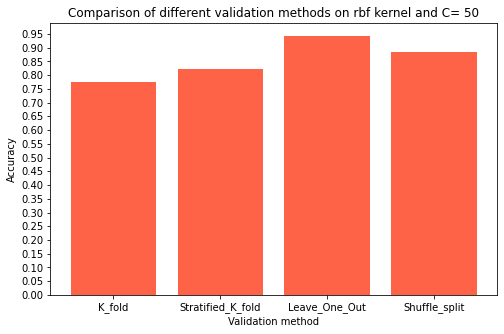

In [26]:
cross_vals = ['K_fold','Stratified_K_fold','Leave_One_Out','Shuffle_split']
results = [scores_kf.mean(),scores_skf.mean(),scores_loo.mean(),scores_ss.mean()]

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on rbf kernel and C= 50")
plt.xlabel("Validation method")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results,color = 'tomato')
plt.show() 


In [87]:
print(scores_ss_f1.mean(), "ss")
print(scores_kf_f1.mean(), "kf")
print(scores_loo_f1.mean(), "loo")
print(scores_skf_f1.mean(), "skf")



0.9 ss
0.7972316384180791 kf
0.9155405405405406 loo
0.8410734463276837 skf


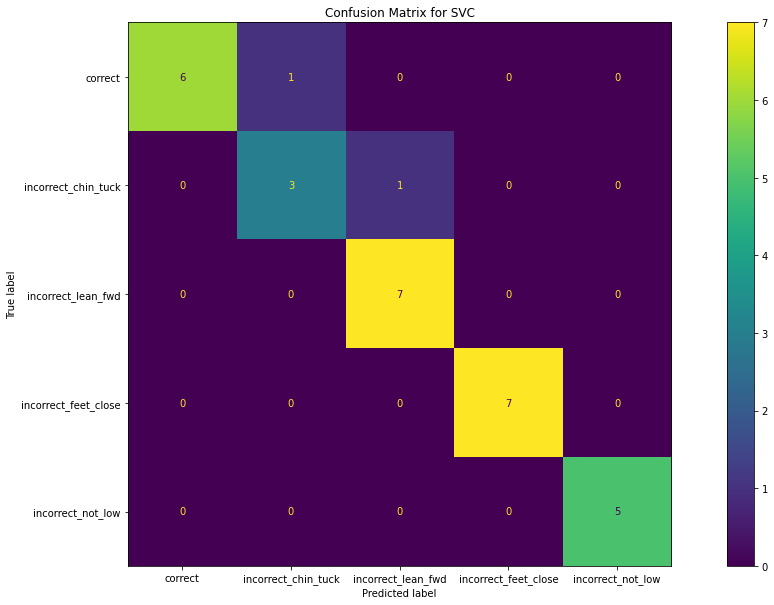

In [88]:
predictions = svc.predict(X_test)
fig, ax = plt.subplots(figsize=(20, 10))
ConfusionMatrixDisplay.from_predictions(y_test, predictions,ax=ax,display_labels=labels)

# set the title and axis labels for the plot
plt.title('Confusion Matrix for SVC')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# show the plot
plt.show()

# KNC

In [13]:
from sklearn.neighbors import KNeighborsClassifier as KNC


In [18]:
n_neighbors = np.arange(3,20)
weights = ['uniform','distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
params = {'n_neighbors':n_neighbors, 'weights':weights,'algorithm':algorithm,'p':[2]}


knc = KNC()
knc_tuning = RandomizedSearchCV(knc, params, scoring='accuracy', n_iter=30, cv=3, verbose=2)

knc_tuning.fit(X_train,y_train)



Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END algorithm=ball_tree, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=13, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=13, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=13, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, n_neighbors=16, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, n_neighbors=16, p=2, weights=distance; total 

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=30,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'p': [2],
                                        'weights': ['uniform', 'distance']},
                   scoring='accuracy', verbose=2)

In [19]:
knc_tuning.best_params_

{'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'algorithm': 'kd_tree'}

In [73]:
knc = KNC(n_neighbors = 3, p = 2, algorithm = 'kd_tree',weights='distance')


In [74]:
knc.fit(X_train,y_train)
knc.score(X_test,y_test)

0.8333333333333334

In [75]:
scores_kf_knc = cross_val_score(knc, X, y, cv = k_folds, scoring='f1_micro')
scores_skf_knc = cross_val_score(knc, X, y, cv = sk_folds, scoring='f1_micro')
scores_loo_knc = cross_val_score(knc, X, y, cv = loo, scoring='f1_micro')
scores_ss_knc = cross_val_score(knc, X, y, cv = ss, scoring='f1_micro')

In [76]:
print(scores_kf_knc.mean(),"k_fold")
print(scores_skf_knc.mean(),"stratified k_fold")
print(scores_loo_knc.mean(),"loo")
print(scores_ss_knc.mean(),"ss")



0.6357062146892656 k_fold
0.6866666666666668 stratified k_fold
0.8716216216216216 loo
0.7733333333333333 ss


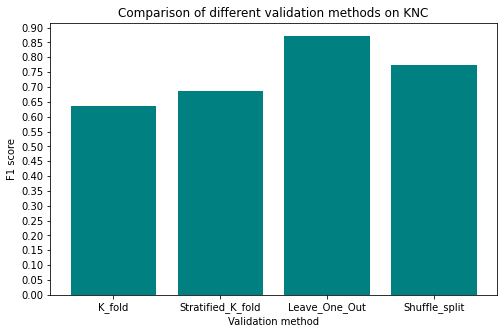

In [78]:
results_knc = [scores_kf_knc.mean(),scores_skf_knc.mean(),scores_loo_knc.mean(),scores_ss_knc.mean()]

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on KNC")
plt.xlabel("Validation method")
plt.ylabel("F1 score")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_knc,color='teal')
plt.show()

In [36]:
scores_kf_knc = cross_val_score(knc, X, y, cv = k_folds)
scores_skf_knc = cross_val_score(knc, X, y, cv = sk_folds)
scores_loo_knc = cross_val_score(knc, X, y, cv = loo)
scores_ss_knc = cross_val_score(knc, X, y, cv = ss)

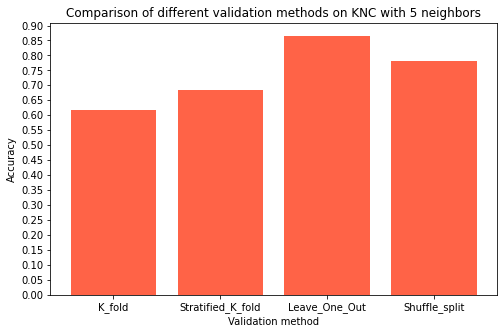

In [37]:
results_knc = [scores_kf_knc.mean(),scores_skf_knc.mean(),scores_loo_knc.mean(),scores_ss_knc.mean()]

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on KNC with 5 neighbors")
plt.xlabel("Validation method")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_knc,color='tomato')
plt.show()

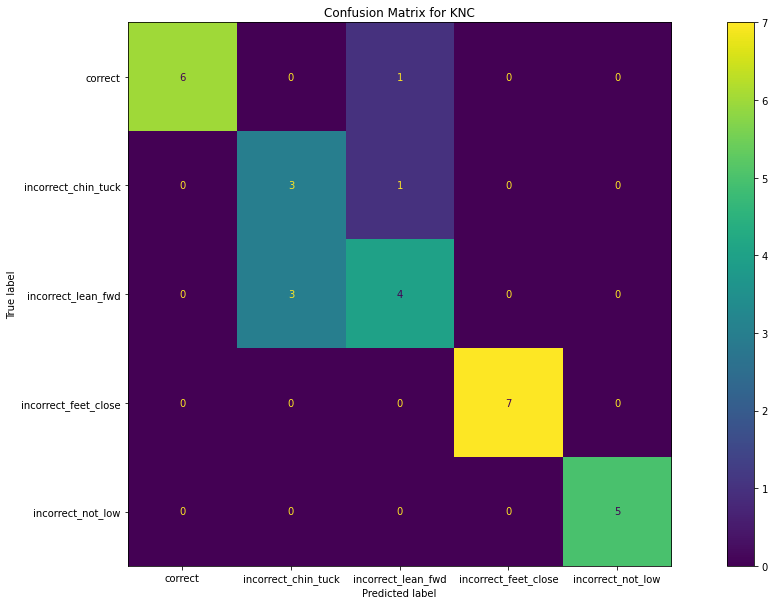

In [30]:
predictions_knc = knc.predict(X_test)
fig, ax = plt.subplots(figsize=(20, 10))
ConfusionMatrixDisplay.from_predictions(y_test, predictions_knc,ax=ax,display_labels=labels)

# set the title and axis labels for the plot
plt.title('Confusion Matrix for KNC')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# show the plot
plt.show()

# Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier as DTC

In [32]:
dtc = DTC()
dtc.fit(X_train,y_train)
dtc.score(X_test,y_test)

0.6

In [33]:
criterion = ['gini', 'entropy', 'log_loss']
max_depth = np.arange(1,150)
random_state = np.arange(0,300)
max_leaf_nodes = np.arange(1,150)
params ={'criterion':criterion,'max_depth':max_depth,'random_state':random_state,'max_leaf_nodes':max_leaf_nodes}


dtc_tuning = RandomizedSearchCV(dtc, params, scoring='accuracy', n_iter=30, cv=3, verbose=2)

dtc_tuning.fit(X_train,y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END criterion=log_loss, max_depth=45, max_leaf_nodes=49, random_state=227; total time=   0.0s
[CV] END criterion=log_loss, max_depth=45, max_leaf_nodes=49, random_state=227; total time=   0.0s
[CV] END criterion=log_loss, max_depth=45, max_leaf_nodes=49, random_state=227; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_leaf_nodes=99, random_state=279; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_leaf_nodes=99, random_state=279; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_leaf_nodes=99, random_state=279; total time=   0.0s
[CV] END criterion=log_loss, max_depth=69, max_leaf_nodes=53, random_state=256; total time=   0.0s
[CV] END criterion=log_loss, max_depth=69, max_leaf_nodes=53, random_state=256; total time=   0.0s
[CV] END criterion=log_loss, max_depth=69, max_leaf_nodes=53, random_state=256; total time=   0.0s
[CV] END criterion=entropy, max_depth=23, max_leaf_nodes=74,

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=30,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  7...
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
       260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
       273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
       286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
       299])},
                   scoring='accuracy', verbose=2)

In [34]:
dtc_tuning.best_params_

{'random_state': 22,
 'max_leaf_nodes': 85,
 'max_depth': 17,
 'criterion': 'log_loss'}

In [90]:
dtc_tuned = DTC(random_state = 22, max_leaf_nodes = 85, max_depth = 17, criterion = 'log_loss')
dtc_tuned.fit(X_train,y_train)
dtc_tuned.score(X_test,y_test)

0.6666666666666666

In [91]:
scores_kf_dtc = cross_val_score(dtc_tuned, X, y, cv = k_folds, scoring='f1_micro')
scores_skf_dtc = cross_val_score(dtc_tuned, X, y, cv = sk_folds, scoring='f1_micro')
scores_loo_dtc = cross_val_score(dtc_tuned, X, y, cv = loo, scoring='f1_micro')
scores_ss_dtc = cross_val_score(dtc_tuned, X, y, cv = ss, scoring='f1_micro')

In [92]:
print(scores_kf_dtc.mean(),"k_fold")
print(scores_skf_dtc.mean(),"stratified k_fold")
print(scores_loo_dtc.mean(),"loo")
print(scores_ss_dtc.mean(),"ss")



0.594858757062147 k_fold
0.6959887005649718 stratified k_fold
0.7972972972972973 loo
0.8066666666666666 ss


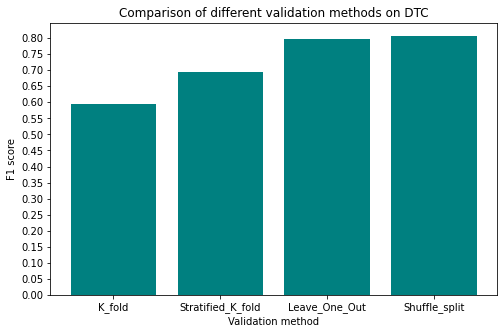

In [93]:
results_dtc = [scores_kf_dtc.mean(),scores_skf_dtc.mean(),scores_loo_dtc.mean(),scores_ss_dtc.mean()]

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on DTC")
plt.xlabel("Validation method")
plt.ylabel("F1 score")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_dtc,color='teal')
plt.show()

In [74]:
scores_kf_dtc = cross_val_score(dtc_tuned, X, y, cv = k_folds)
scores_skf_dtc = cross_val_score(dtc_tuned, X, y, cv = sk_folds)
scores_loo_dtc = cross_val_score(dtc_tuned, X, y, cv = loo)
scores_ss_dtc = cross_val_score(dtc_tuned, X, y, cv = ss)

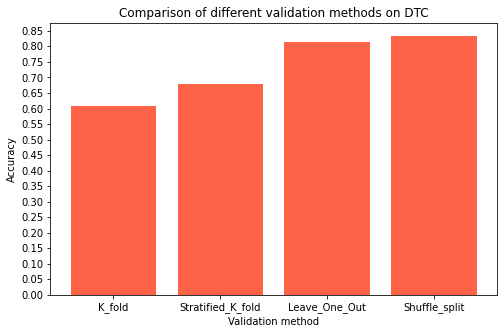

In [75]:
results_dtc = [scores_kf_dtc.mean(),scores_skf_dtc.mean(),scores_loo_dtc.mean(),scores_ss_dtc.mean()]

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on DTC")
plt.xlabel("Validation method")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_dtc,color='tomato')
plt.show()

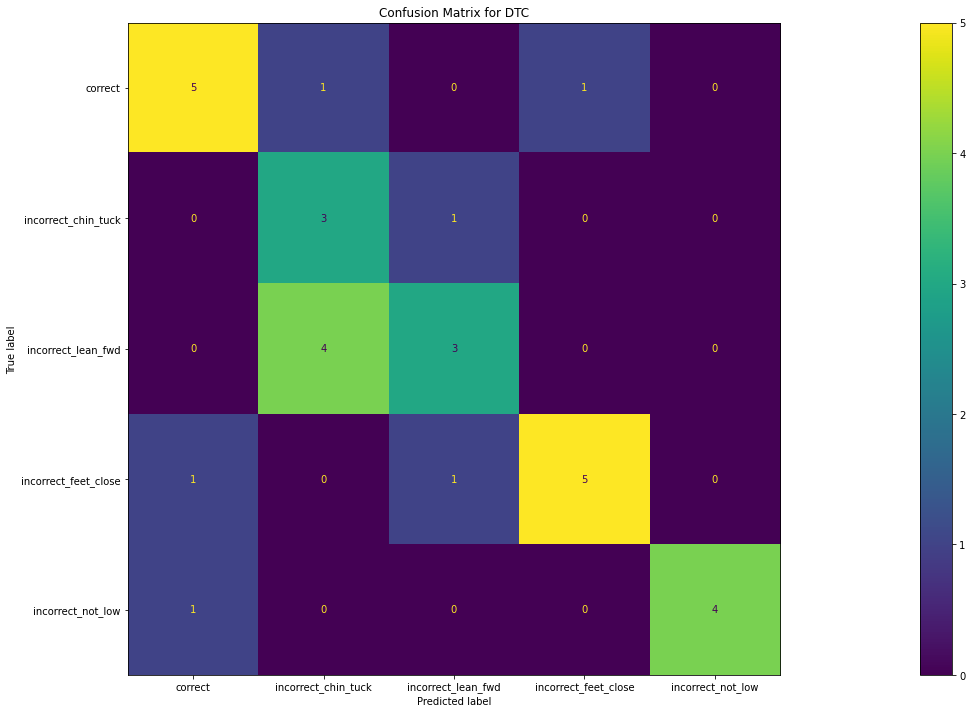

In [95]:
labels_dtc = ['correct','incorrect_chin_tuck','incorrect_lean_fwd','incorrect_feet_close','incorrect_not_low','incorrect_out_knees']

predictions_dtc = dtc_tuned.predict(X_test)
fig, ax = plt.subplots(figsize=(50, 12))
ConfusionMatrixDisplay.from_predictions(y_test, predictions_dtc,ax=ax,display_labels=labels_dtc[:5])

# set the title and axis labels for the plot
plt.title('Confusion Matrix for DTC')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# show the plot
plt.show()

# Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [43]:
rfc = RFC(15,random_state = 22, max_leaf_nodes = 85, max_depth = 17, criterion = 'log_loss')

In [44]:
rfc.fit(X_train,y_train)
rfc.score(X_test,y_test)

0.8

In [45]:
num_models = np.arange(1,31)
scores_rfc =[]
for i in num_models:
    rfc = RFC(i,random_state = 262, max_leaf_nodes = 130, max_depth = 120, criterion = 'entropy')
    rfc.fit(X_train,y_train)
    score =rfc.score(X_test,y_test)
    scores_rfc.append(score)
    

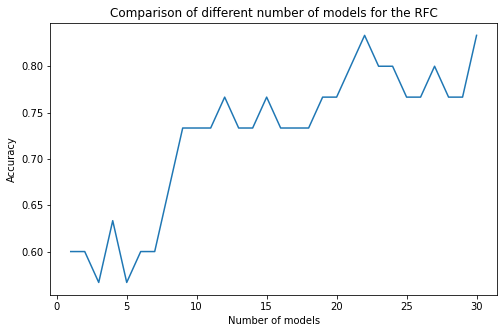

In [46]:
plt.figure(figsize=(8,5))
plt.title("Comparison of different number of models for the RFC")
plt.xlabel("Number of models")
plt.ylabel("Accuracy")
plt.plot(num_models,scores_rfc)

In [50]:
print(scores_rfc.index(max(scores_rfc)))

21


In [101]:

rfc_tuned = RFC(21,random_state = 262, max_leaf_nodes = 130, max_depth = 120, criterion = 'entropy')
rfc_tuned.fit(X_train,y_train)


RandomForestClassifier(criterion='entropy', max_depth=120, max_leaf_nodes=130,
                       n_estimators=21, random_state=262)

In [102]:
scores_kf_rfc = cross_val_score(rfc_tuned, X, y, cv = k_folds, scoring='f1_micro')
scores_skf_rfc = cross_val_score(rfc_tuned, X, y, cv = sk_folds, scoring='f1_micro')
scores_loo_rfc = cross_val_score(rfc_tuned, X, y, cv = loo, scoring='f1_micro')
scores_ss_rfc = cross_val_score(rfc_tuned, X, y, cv = ss, scoring='f1_micro')


In [103]:
print(scores_kf_rfc.mean(),"k_fold")
print(scores_skf_rfc.mean(),"stratified k_fold")
print(scores_loo_rfc.mean(),"loo")
print(scores_ss_rfc.mean(),"ss")



0.7404519774011299 k_fold
0.7838418079096046 stratified k_fold
0.9324324324324325 loo
0.8766666666666666 ss


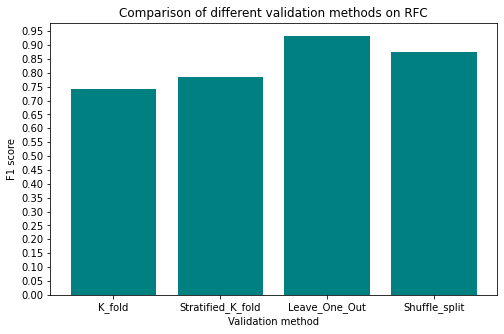

In [104]:
results_rfc = [scores_kf_rfc.mean(),scores_skf_rfc.mean(),scores_loo_rfc.mean(),scores_ss_rfc.mean()]

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on RFC")
plt.xlabel("Validation method")
plt.ylabel("F1 score")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_rfc,color='teal')
plt.show()

In [105]:
print(results_rfc)
print(results_dtc)

[0.7404519774011299, 0.7838418079096046, 0.9324324324324325, 0.8766666666666666]
[0.594858757062147, 0.6959887005649718, 0.7972972972972973, 0.8066666666666666]


In [84]:
scores_kf_rfc = cross_val_score(rfc_tuned, X, y, cv = k_folds)
scores_skf_rfc = cross_val_score(rfc_tuned, X, y, cv = sk_folds)
scores_loo_rfc = cross_val_score(rfc_tuned, X, y, cv = loo)
scores_ss_rfc = cross_val_score(rfc_tuned, X, y, cv = ss)

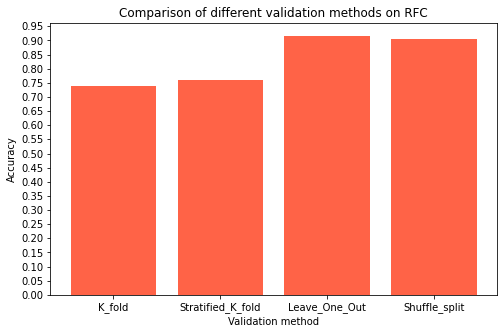

In [86]:
results_rfc = [scores_kf_rfc.mean(),scores_skf_rfc.mean(),scores_loo_rfc.mean(),scores_ss_rfc.mean()]

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on RFC")
plt.xlabel("Validation method")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_rfc,color='tomato')
plt.show()

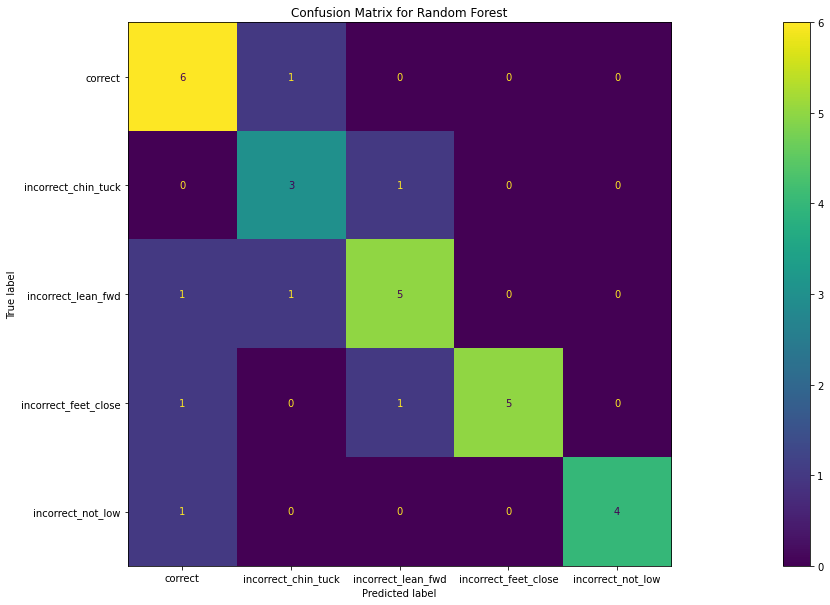

In [106]:
predictions_rfc = rfc_tuned.predict(X_test)
fig, ax = plt.subplots(figsize=(40, 10))
ConfusionMatrixDisplay.from_predictions(y_test, predictions_rfc,ax=ax,display_labels=labels)

# set the title and axis labels for the plot
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# show the plot
plt.show()

## SMOTEENN

In [16]:
from imblearn.over_sampling import ADASYN,SMOTE,BorderlineSMOTE
from imblearn.combine import SMOTEENN

In [17]:
smoteenn = SMOTEENN(smote=SMOTE(k_neighbors=4), random_state=42, sampling_strategy='not majority')


In [18]:
X_resampled, y_resampled = smoteenn.fit_resample(X_t, y)

In [19]:
X_resampled.shape

(332, 40)

In [20]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_resampled,y_resampled, test_size=0.1, random_state=42)

In [21]:
k_folds = KFold(n_splits = 5)
sk_folds = StratifiedKFold(n_splits = 5)
loo = LeaveOneOut()
ss = ShuffleSplit(train_size=0.6, test_size=0.2, n_splits = 5)

## SVM on resampled dataset

In [22]:
svc = SVC(C=48)

svc.fit(X_train_res,y_train_res)



SVC(C=48)

In [24]:
scores_kf_res_f1 = cross_val_score(svc, X_resampled, y_resampled, cv = k_folds,scoring='f1_micro')
scores_skf_res_f1 = cross_val_score(svc, X_resampled, y_resampled, cv = sk_folds,scoring='f1_micro')
scores_loo_res_f1 = cross_val_score(svc, X_resampled, y_resampled, cv = loo,scoring='f1_micro')
scores_ss_res_f1 = cross_val_score(svc, X_resampled, y_resampled, cv = ss,scoring='f1_micro')


In [25]:
print(scores_kf_res_f1.mean(), "kf")
print(scores_skf_res_f1.mean(), "skf")
print(scores_loo_res_f1.mean(), "loo")
print(scores_ss_res_f1.mean(), "ss")

0.4328358208955224 kf
0.9342379014020805 skf
0.9700598802395209 loo
0.9253731343283583 ss


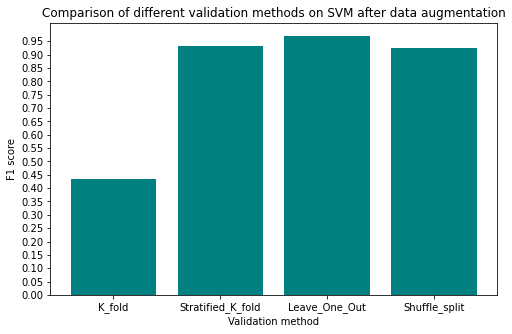

In [43]:
results_svm_res = [scores_kf_res_f1.mean(),scores_skf_res_f1.mean(),scores_loo_res_f1.mean(),scores_ss_res_f1.mean()]

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on SVM after data augmentation")
plt.xlabel("Validation method")
plt.ylabel("F1 score")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_svm_res,color='teal')
plt.show()

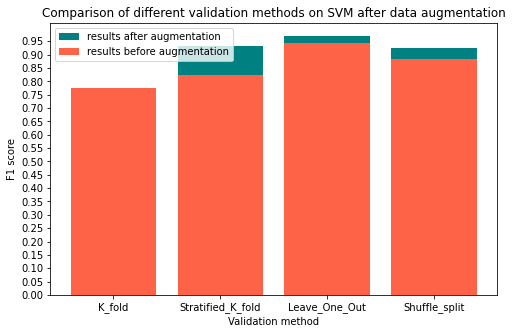

In [70]:

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on SVM after data augmentation")
plt.xlabel("Validation method")
plt.ylabel("F1 score")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_svm_res,color='teal',label='results after augmentation')
plt.bar(cross_vals,results,color='tomato',label= 'results before augmentation')
plt.legend()
plt.show()

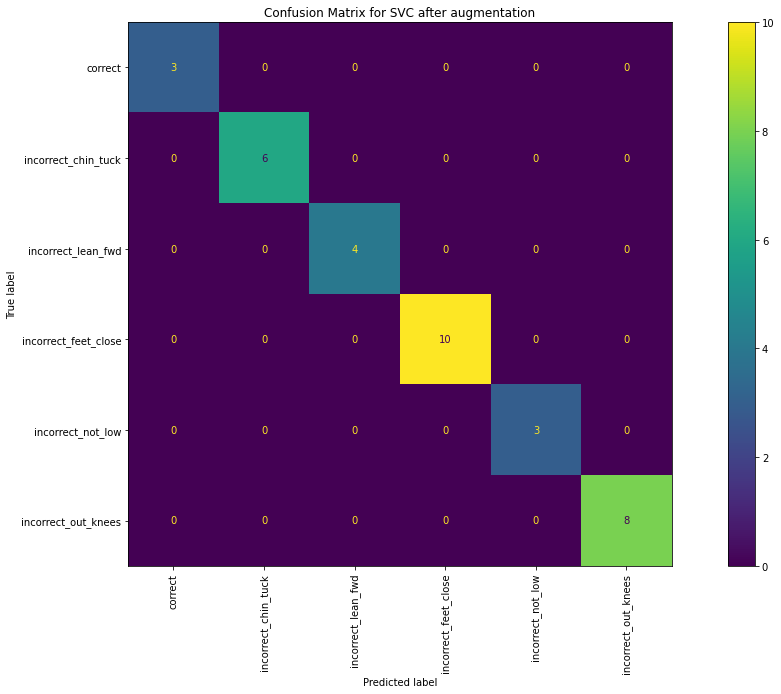

In [24]:
predictions = svc.predict(X_test_res)
fig, ax = plt.subplots(figsize=(20, 10))
labels_full = ['correct','incorrect_chin_tuck','incorrect_lean_fwd','incorrect_feet_close','incorrect_not_low','incorrect_out_knees']

ConfusionMatrixDisplay.from_predictions(y_test_res, predictions,ax=ax,display_labels=labels_full)

# set the title and axis labels for the plot
plt.title('Confusion Matrix for SVC after augmentation')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.setp(ax.get_xticklabels(),rotation=90)
# show the plot
plt.show()

## KNC on resampled dataset

In [25]:
knc = KNC(n_neighbors = 3, p = 2, algorithm = 'kd_tree',weights='distance')
knc.fit(X_train_res,y_train_res)


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=3, weights='distance')

In [80]:
scores_kf_knc_res_f1 = cross_val_score(knc, X_resampled, y_resampled, cv = k_folds,scoring='f1_micro')
scores_skf_knc_res_f1 = cross_val_score(knc, X_resampled, y_resampled, cv = sk_folds,scoring='f1_micro')
scores_loo_knc_res_f1 = cross_val_score(knc, X_resampled, y_resampled, cv = loo,scoring='f1_micro')
scores_ss_knc_res_f1 = cross_val_score(knc, X_resampled, y_resampled, cv = ss,scoring='f1_micro')


In [82]:
print(scores_kf_knc_res_f1.mean(), "kf")
print(scores_skf_knc_res_f1.mean(), "skf")
print(scores_loo_knc_res_f1.mean(), "loo")
print(scores_ss_knc_res_f1.mean(), "ss")

results_knn_res = [scores_kf_knc_res_f1.mean(),scores_skf_knc_res_f1.mean(),scores_loo_knc_res_f1.mean(),scores_ss_knc_res_f1.mean()]

0.35368611488014473 kf
0.9127091813658978 skf
0.9788519637462235 loo
0.9641791044776118 ss


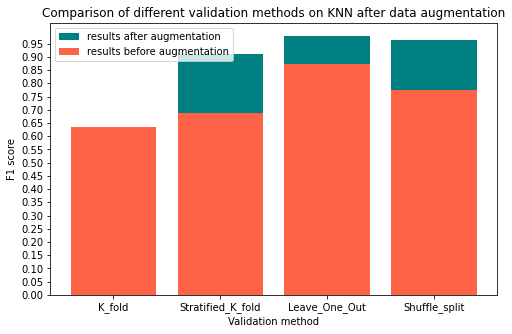

In [83]:
plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on KNN after data augmentation")
plt.xlabel("Validation method")
plt.ylabel("F1 score")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_knn_res,color='teal',label='results after augmentation')
plt.bar(cross_vals,results_knc,color='tomato',label= 'results before augmentation')
plt.legend()
plt.show()

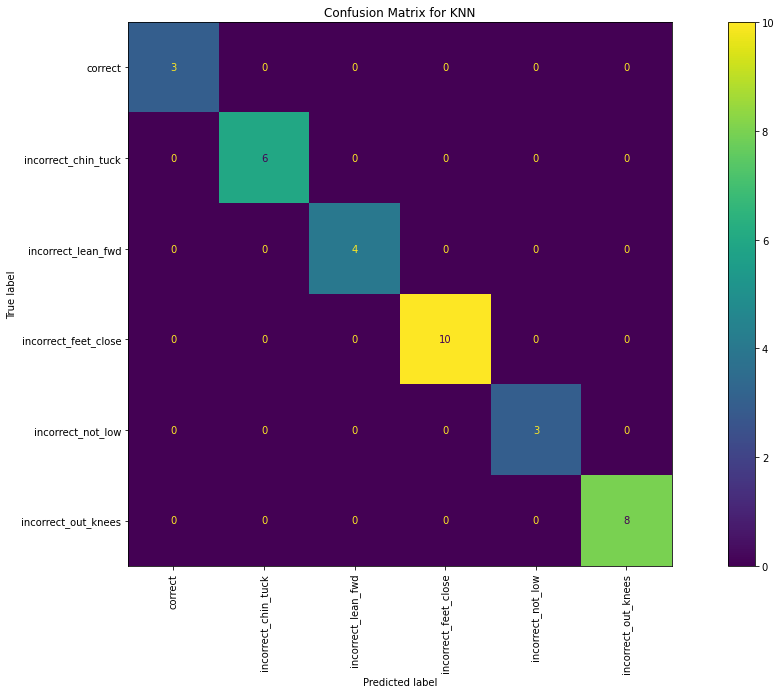

In [26]:
predictions = knc.predict(X_test_res)
fig, ax = plt.subplots(figsize=(20, 10))
labels_full = ['correct','incorrect_chin_tuck','incorrect_lean_fwd','incorrect_feet_close','incorrect_not_low','incorrect_out_knees']

ConfusionMatrixDisplay.from_predictions(y_test_res, predictions,ax=ax,display_labels=labels_full)

# set the title and axis labels for the plot
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.setp(ax.get_xticklabels(),rotation=90)

# show the plot
plt.show()

## Decision Tree on resampled dataset

In [27]:
dtc_tuned = DTC(random_state = 22, max_leaf_nodes = 85, max_depth = 17, criterion = 'log_loss')
dtc_tuned.fit(X_train_res,y_train_res)


DecisionTreeClassifier(criterion='log_loss', max_depth=17, max_leaf_nodes=85,
                       random_state=22)

In [97]:
scores_kf_dtc_res_f1 = cross_val_score(dtc_tuned, X_resampled, y_resampled, cv = k_folds,scoring='f1_micro')
scores_skf_dtc_res_f1 = cross_val_score(dtc_tuned, X_resampled, y_resampled, cv = sk_folds,scoring='f1_micro')
scores_loo_dtc_res_f1 = cross_val_score(dtc_tuned, X_resampled, y_resampled, cv = loo,scoring='f1_micro')
scores_ss_dtc_res_f1 = cross_val_score(dtc_tuned, X_resampled, y_resampled, cv = ss,scoring='f1_micro')


In [98]:
print(scores_kf_dtc_res_f1.mean(), "kf")
print(scores_skf_dtc_res_f1.mean(), "skf")
print(scores_loo_dtc_res_f1.mean(), "loo")
print(scores_ss_dtc_res_f1.mean(), "ss")

0.3175938489371325 kf
0.8130257801899592 skf
0.8942598187311178 loo
0.8537313432835821 ss


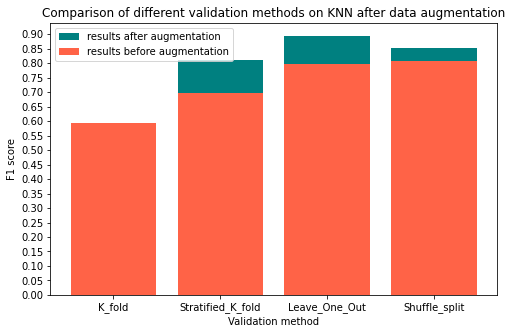

In [99]:
results_dtc_res = [scores_kf_dtc_res_f1.mean(),scores_skf_dtc_res_f1.mean(),scores_loo_dtc_res_f1.mean(),scores_ss_dtc_res_f1.mean()]
plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on KNN after data augmentation")
plt.xlabel("Validation method")
plt.ylabel("F1 score")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_dtc_res,color='teal',label='results after augmentation')
plt.bar(cross_vals,results_dtc,color='tomato',label= 'results before augmentation')
plt.legend()
plt.show()

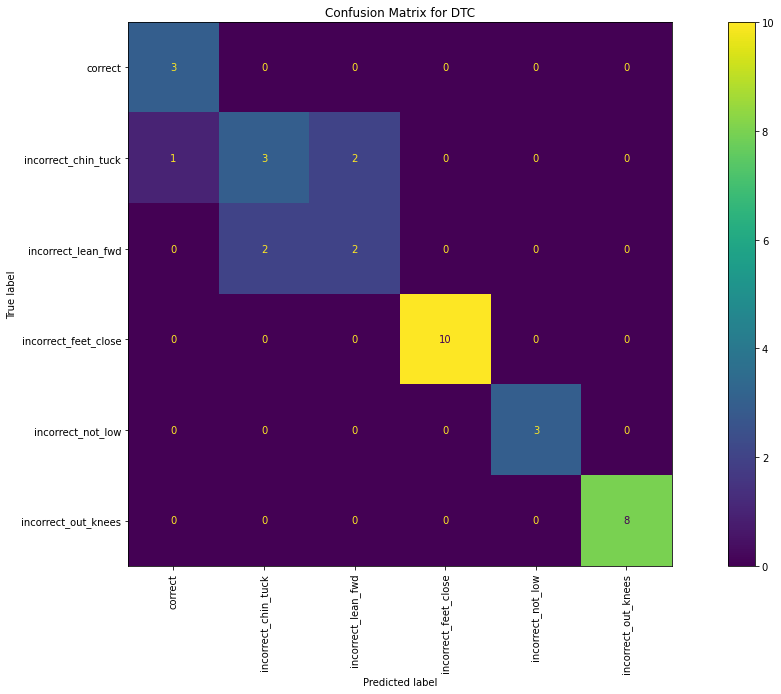

In [32]:
predictions = dtc_tuned.predict(X_test_res)
fig, ax = plt.subplots(figsize=(20, 10))
labels_full = ['correct','incorrect_chin_tuck','incorrect_lean_fwd','incorrect_feet_close','incorrect_not_low','incorrect_out_knees']

ConfusionMatrixDisplay.from_predictions(y_test_res, predictions,ax=ax,display_labels=labels_full)

# set the title and axis labels for the plot
plt.title('Confusion Matrix for DTC')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.setp(ax.get_xticklabels(),rotation=90)
# show the plot
plt.show()

## Random forest on resampled dataset

In [33]:
rfc = RFC(15,random_state = 22, max_leaf_nodes = 85, max_depth = 17, criterion = 'log_loss')
rfc.fit(X_train_res,y_train_res)


RandomForestClassifier(criterion='log_loss', max_depth=17, max_leaf_nodes=85,
                       n_estimators=15, random_state=22)

In [109]:
scores_kf_rfc_res_f1 = cross_val_score(rfc, X_resampled, y_resampled, cv = k_folds,scoring='f1_micro')
scores_skf_rfc_res_f1 = cross_val_score(rfc, X_resampled, y_resampled, cv = sk_folds,scoring='f1_micro')
scores_loo_rfc_res_f1 = cross_val_score(rfc, X_resampled, y_resampled, cv = loo,scoring='f1_micro')
scores_ss_rfc_res_f1 = cross_val_score(rfc, X_resampled, y_resampled, cv = ss,scoring='f1_micro')


In [110]:
print(scores_kf_rfc_res_f1.mean(), "kf")
print(scores_skf_rfc_res_f1.mean(), "skf")
print(scores_loo_rfc_res_f1.mean(), "loo")
print(scores_ss_rfc_res_f1.mean(), "ss")

0.3266847580280416 kf
0.867209407507915 skf
0.9214501510574018 loo
0.8716417910447761 ss


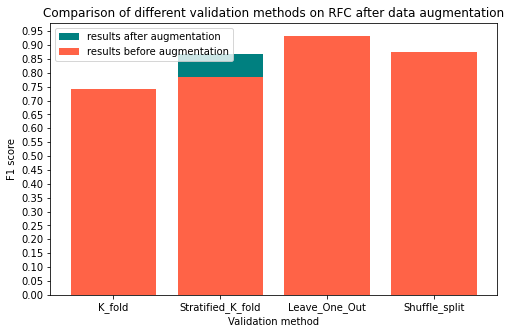

In [112]:
results_rfc_res = [scores_kf_rfc_res_f1.mean(), scores_skf_rfc_res_f1.mean(), scores_loo_rfc_res_f1.mean(),scores_ss_rfc_res_f1.mean()]
plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on RFC after data augmentation")
plt.xlabel("Validation method")
plt.ylabel("F1 score")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_rfc_res,color='teal',label='results after augmentation')
plt.bar(cross_vals,results_rfc,color='tomato',label= 'results before augmentation')
plt.legend()
plt.show()

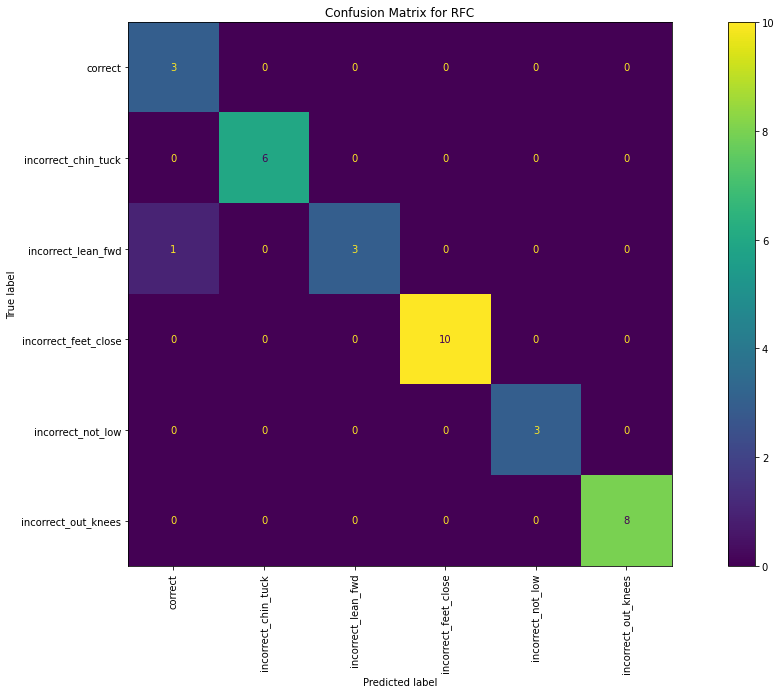

In [35]:
predictions = rfc.predict(X_test_res)
fig, ax = plt.subplots(figsize=(20, 10))
labels_full = ['correct','incorrect_chin_tuck','incorrect_lean_fwd','incorrect_feet_close','incorrect_not_low','incorrect_out_knees']

ConfusionMatrixDisplay.from_predictions(y_test_res, predictions,ax=ax,display_labels=labels_full)

# set the title and axis labels for the plot
plt.title('Confusion Matrix for RFC')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.setp(ax.get_xticklabels(),rotation=90)
# show the plot
plt.show()

## Attempt at ANN

In [64]:
from sklearn.neural_network import MLPClassifier as MLP

In [65]:
mlp = MLP((40,40,40,40,40,40,40,40,40,60,80,80,80,60,60,60,60,40,20),solver = 'lbfgs', verbose = True)

In [66]:
mlp.fit(X_train_res,y_train_res)

MLPClassifier(hidden_layer_sizes=(40, 40, 40, 40, 40, 40, 40, 40, 40, 60, 80,
                                  80, 80, 60, 60, 60, 60, 40, 20),
              solver='lbfgs', verbose=True)

In [67]:
mlp.score(X_test_res,y_test_res)

0.8787878787878788

In [68]:
scores_kf_res_mlp = cross_val_score(mlp, X_resampled, y_resampled, cv = k_folds, scoring='f1_micro')
scores_skf_res_mlp = cross_val_score(mlp, X_resampled, y_resampled, cv = sk_folds, scoring='f1_micro')
scores_loo_res_mlp = cross_val_score(mlp, X_resampled, y_resampled, cv = loo, scoring='f1_micro')
scores_ss_res_mlp = cross_val_score(mlp, X_resampled, y_resampled, cv = ss, scoring='f1_micro')

/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
S

/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
S

/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
S

/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
S

/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
S

/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
S

In [69]:
print(scores_kf_res_mlp.mean())
print(scores_skf_res_mlp.mean())
print(scores_loo_res_mlp.mean())
print(scores_ss_res_mlp.mean())

0.32680652680652683
0.9028438228438228
0.9270516717325228
0.884848484848485
